# Exploratory Data Analysis (RQ4)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests, json
from collections import Counter
import re
from nltk.stem import WordNetLemmatizer 
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.corpus import words, stopwords 
nltk.download('words')
nltk.download('punkt')
import gensim.downloader as api
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /Users/paula/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/paula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/paula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
train = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')  
test = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')  
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (41157, 6)
Test shape :  (3798, 6)


In [3]:
train.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [4]:
# Drop NaN values
train.dropna(subset=['OriginalTweet'], inplace=True)
test.dropna(subset=['OriginalTweet'], inplace=True)
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (41157, 6)
Test shape :  (3798, 6)


In [5]:
# Merging the test and train data 
df = pd.concat([train, test], ignore_index=True)

### Sentiment column analysis

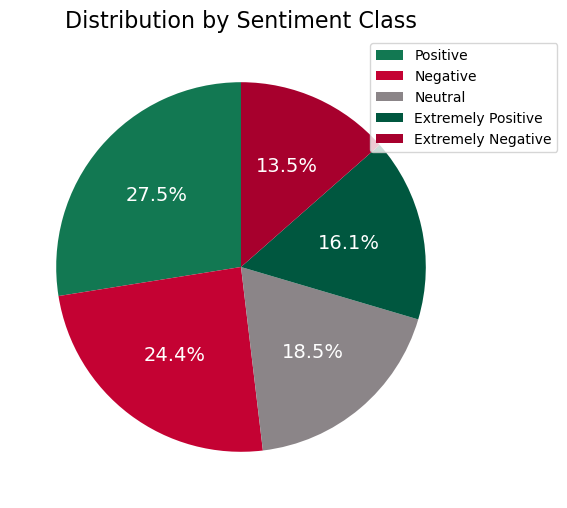

In [6]:
# number of tweets for each sentiment
sentiment_counts = df["Sentiment"].value_counts()

# labels and colors for the pie chart
labels = ["Positive", "Negative", "Neutral", "Extremely Positive", "Extremely Negative"]
colors = ['#127852', '#C40233', '#8B8588', '#00573F', '#A7002D']

# plot the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sentiment_counts, labels=['']*len(labels), colors=colors, autopct='%1.1f%%', startangle=90,
       textprops={'color': 'white', 'fontsize': 14})

plt.title("Distribution by Sentiment Class", fontsize=16)
ax.legend(labels, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

#### Check class distribution

In [7]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

### Load clean dataset (non-lemmatized)

In [8]:
# load the training data 
X_train = pd.read_csv("data/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train = pd.read_csv("data/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# load the validation data 
X_val = pd.read_csv("data/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val = pd.read_csv("data/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# load the test data 
X_test = pd.read_csv("data/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test = pd.read_csv("data/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

### Create dataframes of the clean tweets

In [9]:
df_train = pd.DataFrame({'CleanTweet': X_train, 'Sentiment': y_train})
df_val = pd.DataFrame({'CleanTweet': X_val, 'Sentiment': y_val})
df_test = pd.DataFrame({'CleanTweet': X_test, 'Sentiment': y_test})

# concatenate the dfs vertically
df_tweets = pd.concat([df_train, df_val, df_test], axis=0)
df_tweets = df_tweets.reset_index(drop=True) # reset index

In [10]:
df_tweets.head()

,CleanTweet,Sentiment
0,working grocery store right sounds like hell,0
1,grocery stores coronavirus tipping point ausai...,1
2,suppliers increased prices retail outlets cash...,2
3,direct consumer companies wade coronavirus tes...,1
4,coal remains biggest consumer water south afri...,2


## Word cloud using FastText vocab
Create a word cloud of the most common non-standard words (special Covid-19 lingo, or made up words)

In [11]:
# load pre-trained FastText model
model = api.load('fasttext-wiki-news-subwords-300')

In [12]:
# tokenize tweets and filter out the standard English words
non_standard_words = []
for tweet in df_tweets['CleanTweet']:
    tokens = nltk.word_tokenize(tweet)
    for token in tokens:
        if token.lower() not in model.key_to_index:
            non_standard_words.append(token.lower())

In [13]:
# count the occurrences of each word
word_counts = Counter(non_standard_words)

# create a DataFrame with 2 columns: 'Word' and 'Count'
word_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

# store word counts in a DataFrame
word_count_df = word_count_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# view word counts of non-standard words
# word_count_df

# remove noisy data
noise = ['covid','covid_19','covid1','covid19', 'covid_', 'coronavirusoutbreak','covid2019','covid-19','covid19uk','coronavirusuk','panicbuyinguk','covid__19','covid19us','_','covid19out','covd19']

def remove_strings_from_list(strings_list, strings_to_remove):
    return [s for s in strings_list if s not in strings_to_remove]

non_standard_words = remove_strings_from_list(non_standard_words, noise)

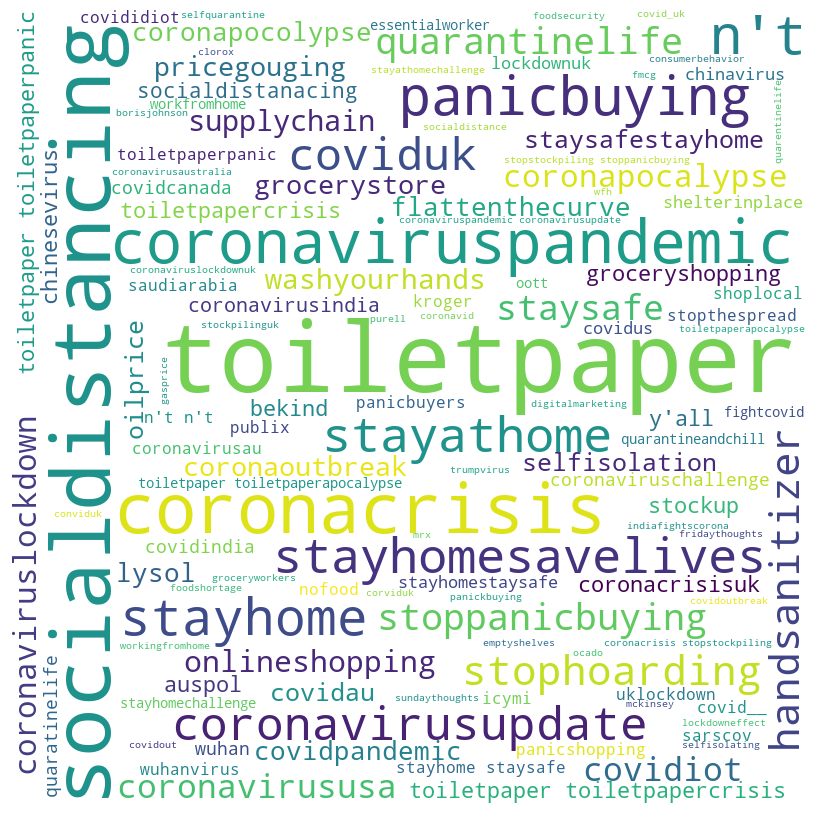

In [14]:
# create a word cloud of the most common non-standard words
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(non_standard_words))

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Find slang prevalence

In [15]:
def create_slang_dict():
    """
    Creates a dictionary of internet slang and their meanings by scraping the NetLingo website.

    Returns:
        dict: A dictionary of internet slang and their meanings, with lowercased keys and values.
    """
    # send a GET request to the NetLingo website and parse the HTML response
    response = requests.get("http://www.netlingo.com/acronyms.php")
    soup = BeautifulSoup(response.text, "html.parser")

    # initialize an empty dictionary for storing the slang terms and their meanings
    slangdict = {}
    acronym = ""
    meaning = ""

    # loop through each 'li' element in the HTML that contains a slang term and its meaning
    for div in soup.findAll('div', attrs={'class': 'list_box3'}):
        for li in div.findAll('li'):
            # extract the slang term and its meaning from the 'li' element
            for a in li.findAll('a'):
                acronym = a.text
                meaning = li.text.split(acronym)[1]
                # add the slang term and its meaning to the dictionary
                slangdict[acronym] = meaning
                         
    # create a new dictionary with lowercase keys and values
    slangdict_lower = {}
    for key, value in slangdict.items():
        lowercase_key = key.lower()
        lowercase_value = value.lower() if isinstance(value, str) else value
        slangdict_lower[lowercase_key] = lowercase_value
        
    # return the dictionary of lowercased slang terms & their meanings 
    return slangdict_lower

def count_slang(tweet, slang_dict):
    """
    Counts the number of slang terms in a tweet.

    Args:
        tweet (str): The tweet to count slang terms in.
        slang_dict (dict): A dictionary of internet slang terms and their meanings.

    Returns:
        int: The number of slang terms in the tweet.
    """
     
    # split the tweet into tokens and count the number of slang terms
    tokens = tweet.split()
    slang_words = [token for token in tokens if token.lower() in slang_dict]
    slang_count = sum(1 for token in tokens if token.lower() in slang_dict)
    # return the count of slang terms in the tweet
    return (slang_count, slang_words)

In [16]:
# create dictionary with slang terms
slang_dictionary = create_slang_dict()

# store dictionary with slang terms into JSON file
with open('slang_dictionary.json', 'w') as output_file:
    json.dump(slang_dictionary, output_file, indent=2)

In [17]:
# Manually inspect slang words to remove non-relevant values (not really slang)

# grab Series of slang words present in our dataset
slang_words = df_tweets['CleanTweet'].apply(lambda tweet: count_slang(tweet, slang_dictionary)[1])

# flatten the Series and create a set from the flattened Series
flattened_series = slang_words.explode()
unique_values = set(flattened_series)

# lowercase all value
unique_values_lower = [element.lower() for element in list(unique_values)[1:]] # start from 1 since first value is a nan
unique_values_lower = list(set(unique_values_lower))  # remove duplicates

# Manually inspect slang words to remove non-relevant values for our task
# print(unique_values_lower) 

# create a custom list of slang words to remove from the dictionary
keys_to_remove = ['!', '02', '121', '123', '14', '187', '19', '2', '20', '24/7', '2B', '4', '403', '404', '420', '4Q', '8', '86', '88', '9', '99', '=', '?', '@', 'AB','Ab', 'adidas','as', 'b', 'bn','bm','bo','boat', 'baby','bag','banana', 'base', 'bible',  'blast', 'book','craft','dash','denial','dog', 'danny','dust','fear', 'fine','faith','filth','fire', 'fish','foot', 'fred','gap', 'gas','golf', 'hand', 'henry','joy', 'kiss','love','logo','mia','news','navy','nice', 'ninja','part','picnic','pin','poets','potato','push','rat','smart','shit','spat','stem','swim','time','tingle','tap','tom', 'toy','w','ux','ux', 'was', 'way','we','we', 'word','wt', 'x', 'y','ya', 'yahoo', 'ace', 'z', 'no']

# create a new dictionary with all key-value pairs except those with keys in keys_to_remove
slang_dictionary = {key: value for key, value in slang_dictionary.items() if key not in keys_to_remove}

In [18]:
# add a new column 'SlangCount' to the dataframe that contains the count of slang terms in each tweet
df_tweets['SlangCount'] = df_tweets['CleanTweet'].apply(lambda tweet: count_slang(tweet, slang_dictionary)[0])

# calculate total tokens and slang tokens in the dataset
total_tokens = df_tweets['CleanTweet'].apply(lambda tweet: len(tweet.split())).sum()
total_slang_tokens = df_tweets['SlangCount'].sum()

# calculate the prevalence of slang
slang_prevalence = total_slang_tokens / total_tokens
print(f"Slang prevalence: {slang_prevalence:.2%}")

# assess the level of slang  
if slang_prevalence < 0.01:
    print("Low level of slang")
elif slang_prevalence < 0.05:
    print("Moderate level of slang")
else:
    print("High level of slang")

Slang prevalence: 1.98%
Moderate level of slang


### Word cloud of slang or abbreviations found in the dataset

In [19]:
# define relevant slang words that occur in our dataset
relevant_slang = ['unt','nsfw','b/c','bcoz','psa','some1','idk','idc','esg','wknd','qs','csa', 'swag','cbd','sb','sahm', 'lmk','wb','ffs','gbp','fil','ntm','lf','mil','hodl','hv','fml', 'ctfu','bmw','ty', 'gi','foe','bil','jc','omfg','ng','bc','tbh','iso','tnx','sbi','ngl','fav','cos','dunno','w/o','ofc','wwd','b2c','lmao','asap','atm','nos','msm','rts','mf', 'plz','fab','sup','smb','potus','uv','fud','bro','bff','imo','omg','ima','defo','def','fwd','nev','til','af', 'doin','w/','hbo','asmr', 'cuz','ff']

# loop through tweets in the dataset and store each instance in a list
slang_in_dataset = []

for tweet in df_tweets['CleanTweet']:
    tokens = tweet.split()
    for token in tokens:
        if token in relevant_slang:
            slang_in_dataset.append(token)

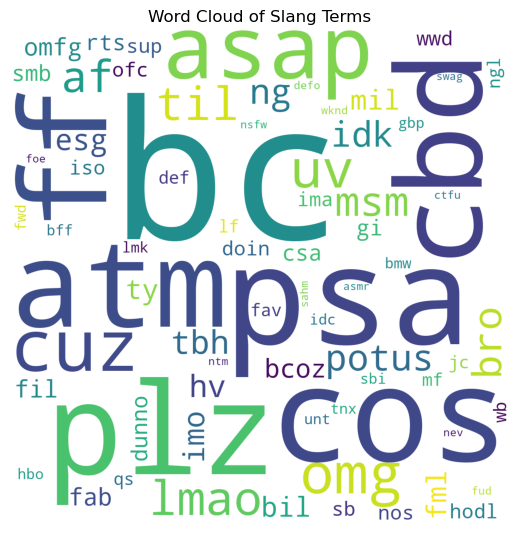

In [20]:
# create a word cloud of the most common non-standard words
wordcloud = WordCloud(width=1200, height=1200, background_color='white', min_font_size=4).generate(' '.join(slang_in_dataset))

# plot the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud of Slang Terms')
plt.show()

### Check vocabulary size of corpus

In [21]:
# combine all tweets into a single string
tweets = ' '.join(df_tweets['CleanTweet'].tolist())

# tokenize the string into a list of words
words = nltk.tokenize.word_tokenize(tweets)

# get the vocabulary size
corpus = list(set(words))
vocab_size = len(corpus)

print('The vocabulary size of the corpus is:', vocab_size)

The vocabulary size of the corpus is: 45683


### Compare vocabulary coverage
Comparing the vocabulary overlap between the corpus in this dataset and pre-trained models can give insight into which models might perform best for this specific use case.

In [22]:
# load the pre-trained models for Word2Vec, GloVe, and FastText
w2v_model = api.load('word2vec-google-news-300')
glove_model = api.load('glove-twitter-25')
ft_model = api.load('fasttext-wiki-news-subwords-300')

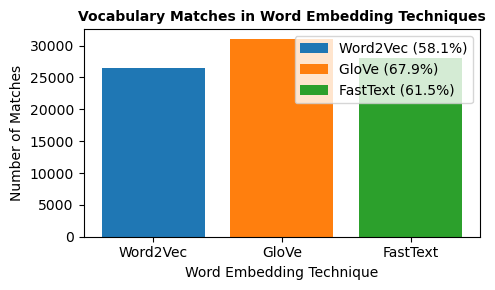

In [23]:
# count the number of words in corpus that are present in each model's vocabulary
w2v_matches = sum(1 for word in corpus if word in w2v_model.key_to_index)
glove_matches = sum(1 for word in corpus if word in glove_model.key_to_index)
ft_matches = sum(1 for word in corpus if word in ft_model.key_to_index)

# calculate the percentages for each word embedding technique
total_words = len(corpus)
w2v_percentage = w2v_matches / total_words * 100
glove_percentage = glove_matches / total_words * 100
ft_percentage = ft_matches / total_words * 100

# create a bar plot showing the number of matches for each word embedding technique
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(['Word2Vec', 'GloVe', 'FastText'], [w2v_matches, glove_matches, ft_matches], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_xlabel('Word Embedding Technique', fontsize=10)
ax.set_ylabel('Number of Matches', fontsize=10)
ax.set_title('Vocabulary Matches in Word Embedding Techniques', fontsize=10, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10)

# create custom legend handles and labels
from matplotlib.patches import Patch

legend_handles = [
    Patch(facecolor='#1f77b4', label=f'Word2Vec ({w2v_percentage:.1f}%)'),
    Patch(facecolor='#ff7f0e', label=f'GloVe ({glove_percentage:.1f}%)'),
    Patch(facecolor='#2ca02c', label=f'FastText ({ft_percentage:.1f}%)')
]

# add the legend to the plot
ax.legend(handles=legend_handles, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [24]:
print(f'Word2Vec vocabulary matches: {w2v_matches} ({round((w2v_matches/vocab_size)*100,1)})%')
print(f'GloVe vocabulary matches: {glove_matches} ({round((glove_matches/vocab_size)*100,1)})%')
print(f'FastText vocabulary matches: {ft_matches} ({round((ft_matches/vocab_size)*100,1)})%') 

Word2Vec vocabulary matches: 26554 (58.1)%
GloVe vocabulary matches: 31007 (67.9)%
FastText vocabulary matches: 28078 (61.5)%


### Frequency Distribution of Words (CleanTweets)
Explore the distribution of word frequencies in the dataset to determine if there are a large number of rare words, which may make it difficult for word embeddings to capture meaningful relationships between words. 

In [25]:
# load stopwords
stop_words = set(stopwords.words('english'))

# remove stopwords
df_tweets['CleanTweet'] = df_tweets['CleanTweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

In [26]:
# combine all tweets into a single string
tweets = ' '.join(df_tweets['CleanTweet'].tolist())

# tokenize the string into a list of words
words = nltk.tokenize.word_tokenize(tweets)

In [27]:
# calculate the frequency distribution of the words
fdist = FreqDist(words)

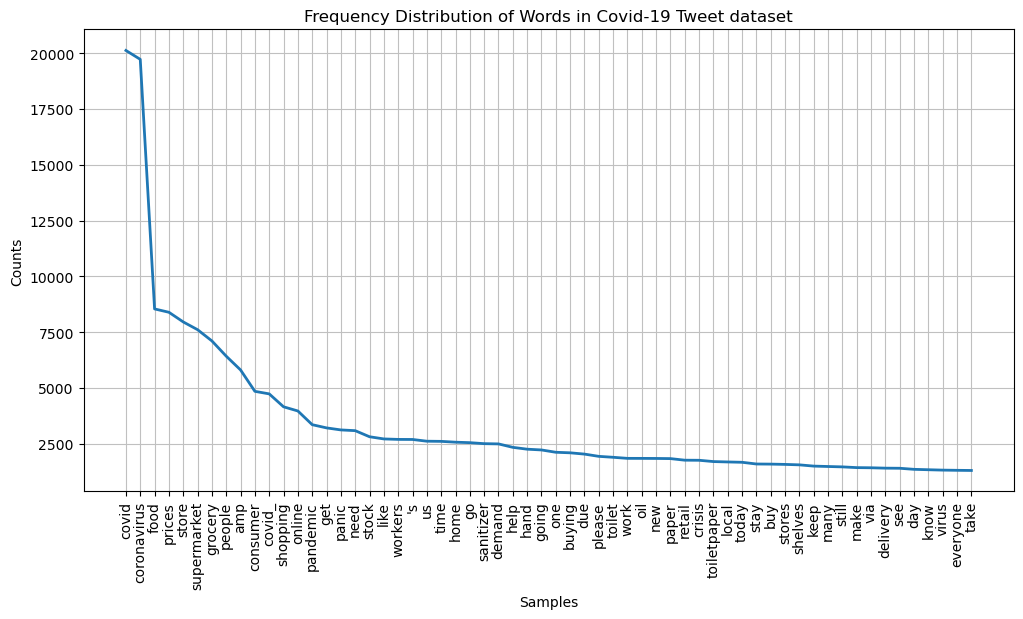

<AxesSubplot: title={'center': 'Frequency Distribution of Words in Covid-19 Tweet dataset'}, xlabel='Samples', ylabel='Counts'>

In [28]:
plt.figure(figsize=(12, 6))
plt.title('Frequency Distribution of Words in Covid-19 Tweet dataset')

# plot the frequency distribution
fdist.plot(60, cumulative=False)

In [29]:
# Get a list of the top 50 most common words without the counts
top_1000_words = [word for word, count in fdist.most_common(1000)]

In [30]:
# Count the number of words in corpus that are present in each model's vocabulary
w2v_matches = sum(1 for word in top_1000_words if word in w2v_model.key_to_index)
glove_matches = sum(1 for word in top_1000_words if word in glove_model.key_to_index)
ft_matches = sum(1 for word in top_1000_words if word in ft_model.key_to_index)

In [31]:
print(w2v_matches)
print(glove_matches)  # GloVe has the greatest amount of matches for the most common 1000 words in CleanTweets
print(ft_matches) 

970
978
974


### Frequency Distribution of Words (OriginalTweets)

In [32]:
# combine all tweets into a single string
tweets = ' '.join(df['OriginalTweet'].tolist())

# tokenize the string into a list of words
words = nltk.tokenize.word_tokenize(tweets)

In [33]:
# calculate the frequency distribution of the words
fdist = FreqDist(words)

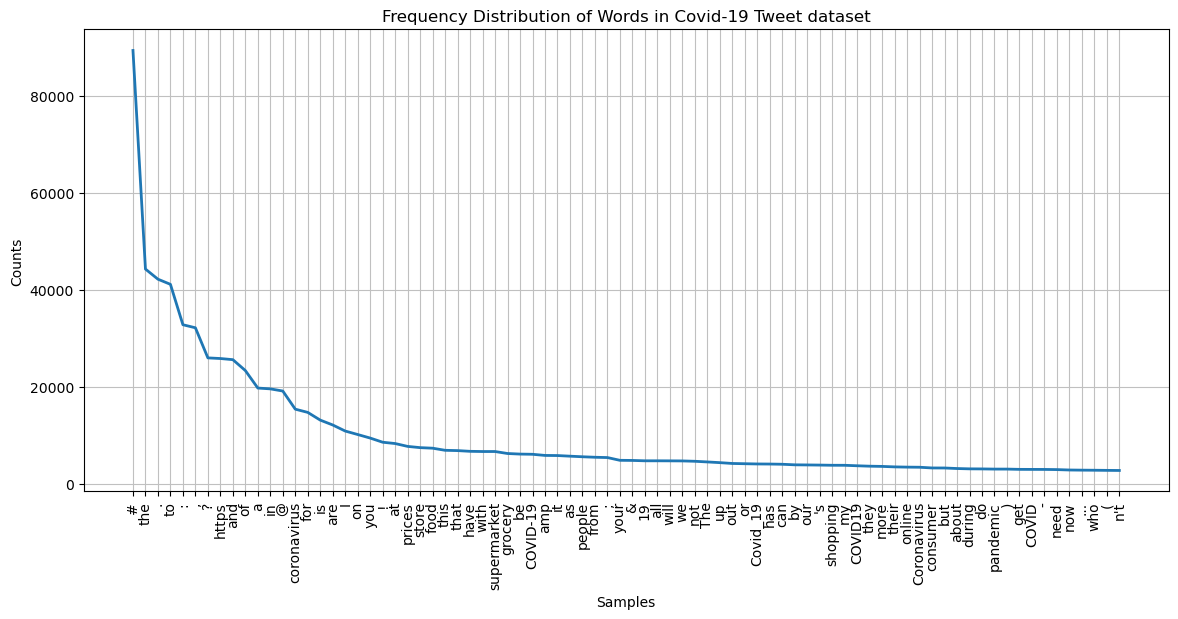

<AxesSubplot: title={'center': 'Frequency Distribution of Words in Covid-19 Tweet dataset'}, xlabel='Samples', ylabel='Counts'>

In [34]:
plt.figure(figsize=(14, 6))
plt.title('Frequency Distribution of Words in Covid-19 Tweet dataset')

# plot the frequency distribution
fdist.plot(80, cumulative=False)

In [35]:
# Get a list of the top 1000 most common words without the counts
top_1000_words = [word for word, count in fdist.most_common(1000)]

In [36]:
# Count the number of words in corpus that are present in each model's vocabulary
w2v_matches = sum(1 for word in top_1000_words if word in w2v_model.key_to_index)
glove_matches = sum(1 for word in top_1000_words if word in glove_model.key_to_index)
ft_matches = sum(1 for word in top_1000_words if word in ft_model.key_to_index)

In [37]:
print(w2v_matches)
print(glove_matches)
print(ft_matches) # Fast Text has the greatest amount of matches for the most common 1000 words in OriginalTweets

916
780
949


In general, FastText is considered to have the most extensive vocabulary due to its ability to generate embeddings for out-of-vocabulary words based on subword information.  This allows FastText to work with an extensive vocabulary, even with words that were not seen during training.  

#### Count unique words of pre-processed tweets (lemmatized)

In [38]:
# Load the training data 
X_train_lemmatized = pd.read_csv("data/lemmatized/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train_lemmatized = pd.read_csv("data/lemmatized/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the validation data 
X_val_lemmatized = pd.read_csv("data/lemmatized/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val_lemmatized = pd.read_csv("data/lemmatized/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the test data 
X_test_lemmatized = pd.read_csv("data/lemmatized/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test_lemmatized = pd.read_csv("data/lemmatized/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

In [39]:
# Merge tweets into one string
tweets_lemmatized = pd.concat([X_train_lemmatized, X_val_lemmatized, X_test_lemmatized])
tweets_lemmatized = ' '.join(tweets_lemmatized)

# tokenize words in each tweet
words_lemmatized = tweets_lemmatized.split()

# count the unique words
unique_words_count_lemmatized = len(set(words_lemmatized))

# print the total amount of unique words
print('Total amount of lemmatized unique words:', unique_words_count_lemmatized)

Total amount of lemmatized unique words: 41547


#### Count unique words of pre-processed tweets (non lemmatized)

In [40]:
# Calculate the word length for each tweet and store in a new Series
all_tweets = df_tweets['CleanTweet']
word_lengths = all_tweets.apply(lambda tweet: len(tweet.split()))

# Calculate the summary statistics of the word lengths
stats = word_lengths.describe()

# Extract the average, median, minimum, and maximum word length
average_word_length = stats['mean']
median_word_length = stats['50%']
min_word_length = stats['min']
max_word_length = stats['max']

# Print the results
print("Average tweet word length:", average_word_length)
print("Median tweet word length:", median_word_length)
print("Minimum tweet word length:", min_word_length)
print("Maximum tweet word length:", max_word_length)

Average tweet word length: 17.705248631082224
Median tweet word length: 18.0
Minimum tweet word length: 1.0
Maximum tweet word length: 46.0


#### Tweet character length

In [41]:
# calculate the length of each tweet
tweet_lengths = all_tweets.str.len()

# calculate average tweet length
avg_tweet_length = tweet_lengths.mean()

# calculate median tweet length
median_tweet_length = tweet_lengths.median()

# calculate minimum tweet length
min_tweet_length = tweet_lengths.min()

# calculate maximum tweet length
max_tweet_length = tweet_lengths.max()

# print the results
print("Average tweet length:", avg_tweet_length)
print("Median tweet length:", median_tweet_length)
print("Minimum tweet length:", min_tweet_length)
print("Maximum tweet length:", max_tweet_length)

Average tweet length: 129.76630458976985
Median tweet length: 135.0
Minimum tweet length: 1
Maximum tweet length: 266


#### Plot Tweet Word Length Distribution by Sentiment

In [42]:
# add tweet_chars and tweet_words to the dataframe
df_tweets['tweet_chars'] = df_tweets.CleanTweet.apply(len)
df_tweets['tweet_words'] = df_tweets['CleanTweet'].apply(lambda x: len(x.split()))
df_tweets.head(3)

,CleanTweet,Sentiment,SlangCount,tweet_chars,tweet_words
0,working grocery store right sounds like hell,0,0,44,7
1,grocery stores coronavirus tipping point ausai...,1,0,73,8
2,suppliers increased prices retail outlets cash...,2,0,55,7


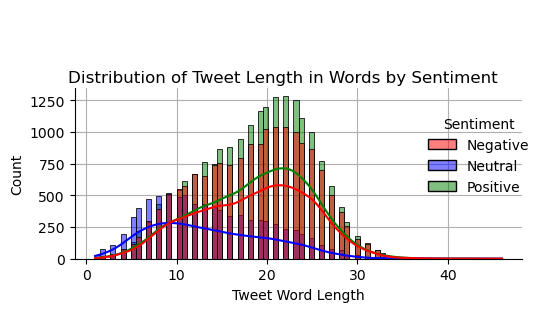

In [43]:
# create a custom color map
color_map = ['red','blue','green']

# map integer sentiment values to string labels
sentiment_labels = df_tweets['Sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

# plot the distribution of tweet characters by sentiment
g = sns.displot(data=df_tweets, x='tweet_words', hue=sentiment_labels, hue_order=['Negative', 'Neutral', 'Positive'], kde=True, height=5, aspect=1.5, palette=color_map)

# set the plot size
g.fig.set_size_inches(5, 2)

# set the x-axis label
g.set(xlabel='Tweet Word Length')

# set the y-axis label
g.set(ylabel='Count')

# set the title
g.fig.suptitle('Distribution of Tweet Length in Words by Sentiment', fontsize=12,y=1.06)

# add legend outside the plot
g.add_legend(bbox_to_anchor=(0.2, 1.4), loc='upper center', ncol=3)

# add gridlines
g.ax.grid(True)

# move gridlines to the background
g.ax.set_axisbelow(True)

# show the plot
plt.show()

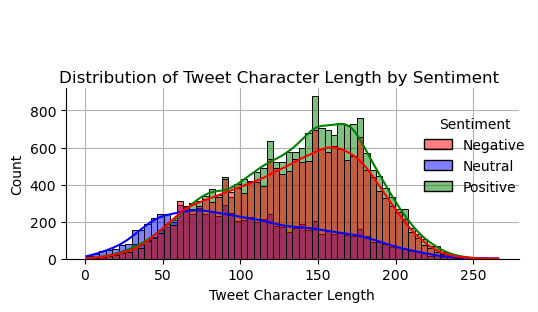

In [45]:
# create a custom color map
color_map = ['red','blue','green']

# map integer sentiment values to string labels
sentiment_labels = df_tweets['Sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

# plot the distribution of tweet characters by sentiment
g = sns.displot(data=df_tweets, x='tweet_chars', hue=sentiment_labels, hue_order=['Negative', 'Neutral', 'Positive'], kde=True, height=5, aspect=1.5, palette=color_map)

# set the plot size
g.fig.set_size_inches(5, 2)

# set the x-axis label
g.set(xlabel='Tweet Character Length')

# set the y-axis label
g.set(ylabel='Count')

# set the title
g.fig.suptitle('Distribution of Tweet Character Length by Sentiment', fontsize=12,y=1.06)

# add legend outside the plot
g.add_legend(bbox_to_anchor=(0.2, 1.4), loc='upper center', ncol=3)

# add gridlines
g.ax.grid(True)

# move gridlines to the background
g.ax.set_axisbelow(True)

# show the plot
plt.show()

In [46]:
df_tweets.describe()

,Sentiment,SlangCount,tweet_chars,tweet_words
count,44926.000000,44926.000000,44926.000000,44926.000000
mean,1.056983,0.349686,129.766305,17.705249
std,0.901049,0.759293,47.543632,6.575320
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,93.000000,13.000000
50%,1.000000,0.000000,135.000000,18.000000
75%,2.000000,0.000000,167.000000,23.000000
max,2.000000,14.000000,266.000000,46.000000


In [47]:
df_tweets.median()

/var/folders/p2/fmvj8hvs1l753rcs5yft1q880000gn/T/ipykernel_26595/2400236667.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_tweets.median()


Sentiment        1.0
SlangCount       0.0
tweet_chars    135.0
tweet_words     18.0
dtype: float64

In [58]:
tweets_series = df_tweets[df_tweets['Sentiment']==0]['CleanTweet']
# calculate the length of each tweet
tweet_lengths = tweets_series.apply(len)
# compute mean and median character length
mean_length = tweet_lengths.mean()
median_length = tweet_lengths.median()
print("Mean character length negative tweets:", mean_length)
print("Median character length negative tweets:", median_length)

tweets_series = df_tweets[df_tweets['Sentiment']==1]['CleanTweet']
# calculate the length of each tweet
tweet_lengths = tweets_series.apply(len)
# compute mean and median character length
mean_length = tweet_lengths.mean()
median_length = tweet_lengths.median()
print("Mean character length neutral tweets:", mean_length)
print("Median character length neutral tweets:", median_length)

tweets_series = df_tweets[df_tweets['Sentiment']==2]['CleanTweet']
# calculate the length of each tweet
tweet_lengths = tweets_series.apply(len)
# compute mean and median character length
mean_length = tweet_lengths.mean()
median_length = tweet_lengths.median()
print("Mean character length positive tweets:", mean_length)
print("Median character length positive tweets:", median_length)

Mean character length negative tweets: 134.31004110393422
Median character length negative tweets: 139.0
Mean character length neutral tweets: 104.08487840115579
Median character length neutral tweets: 98.0
Mean character length positive tweets: 136.7050535987749
Median character length positive tweets: 142.0


### Display most frequent N-grams

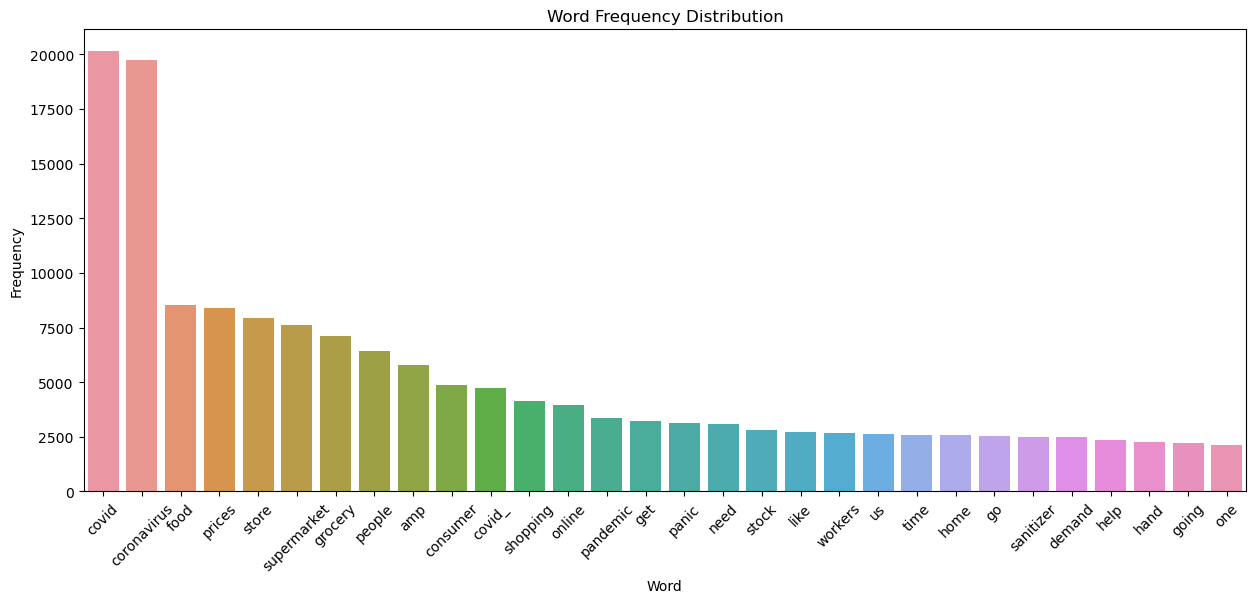

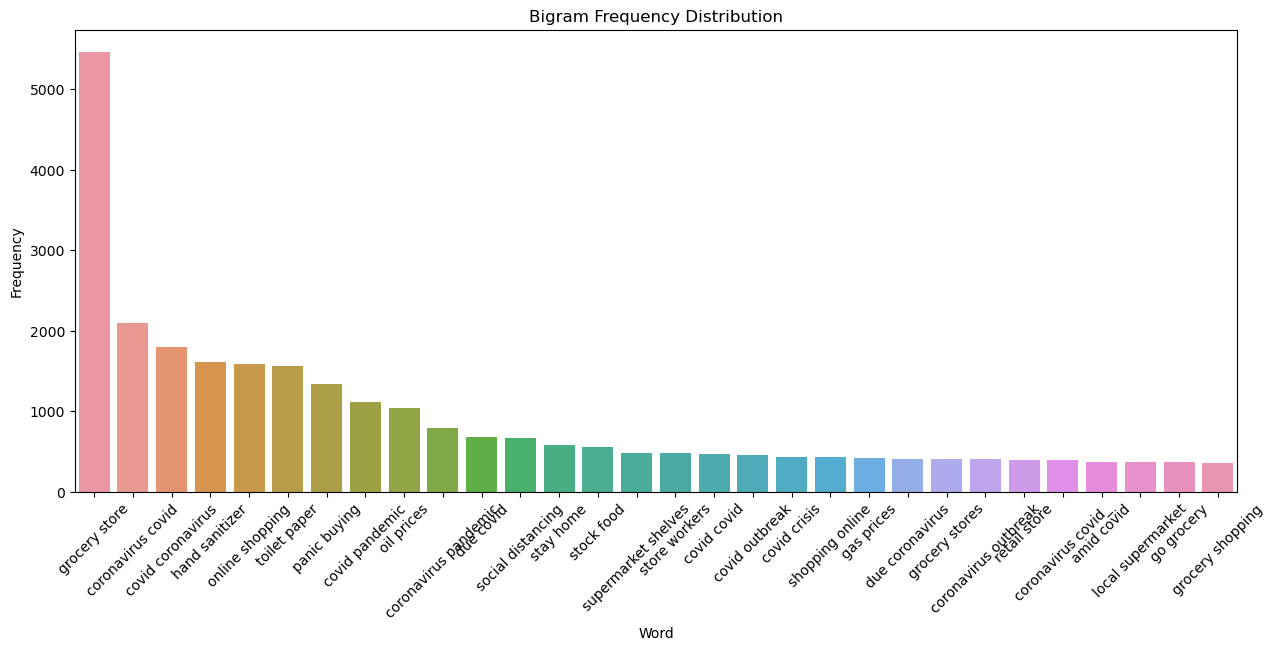

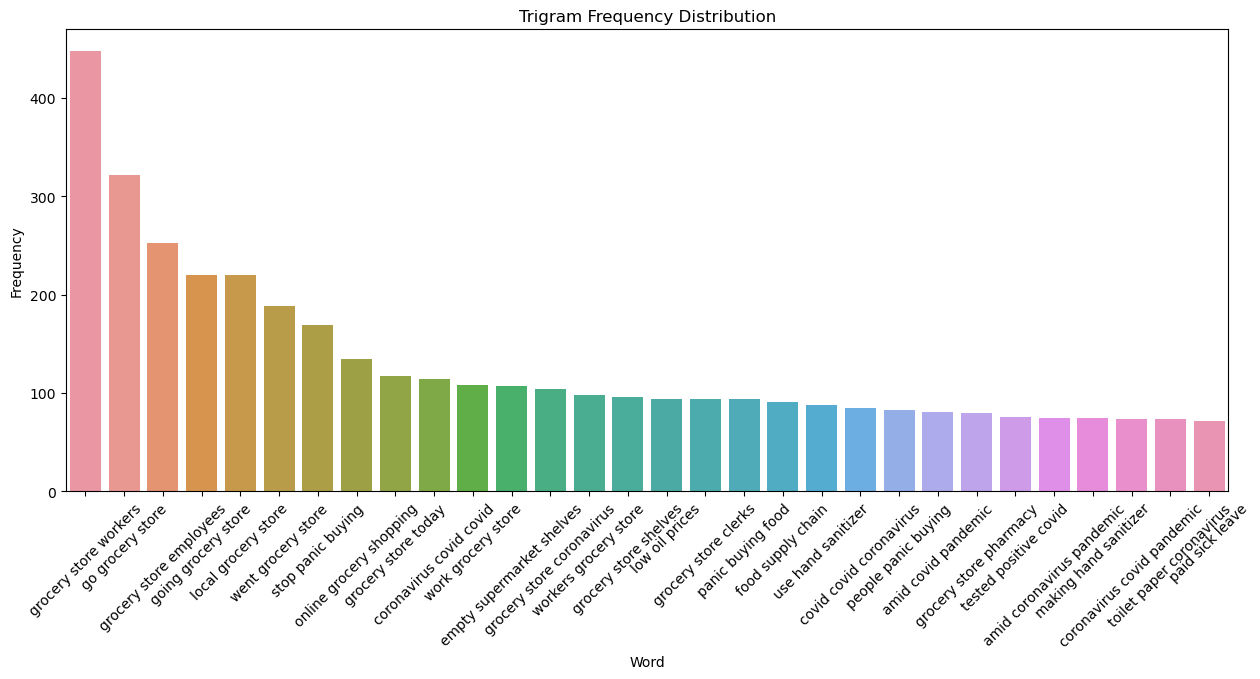

In [59]:
def plot_word_frequency(df, column, n_most_common=30, ngram_range=(1, 1), title='Word Frequency Distribution'):
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    words_matrix = count_vectorizer.fit_transform(df[column])
    words_sum = words_matrix.sum(axis=0)
    words_freq = [(word, words_sum[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n_most_common]
    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

    plt.figure(figsize=(15, 6))
    sns.barplot(x='Word', y='Frequency', data=df_common_words)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Visualize the most frequent words
plot_word_frequency(df_tweets, 'CleanTweet', title='Word Frequency Distribution')

# Visualize the most frequent bigrams
plot_word_frequency(df_tweets, 'CleanTweet', ngram_range=(2, 2), title='Bigram Frequency Distribution')

# Visualize the most frequent trigrams
plot_word_frequency(df_tweets, 'CleanTweet', ngram_range=(3, 3), title='Trigram Frequency Distribution')

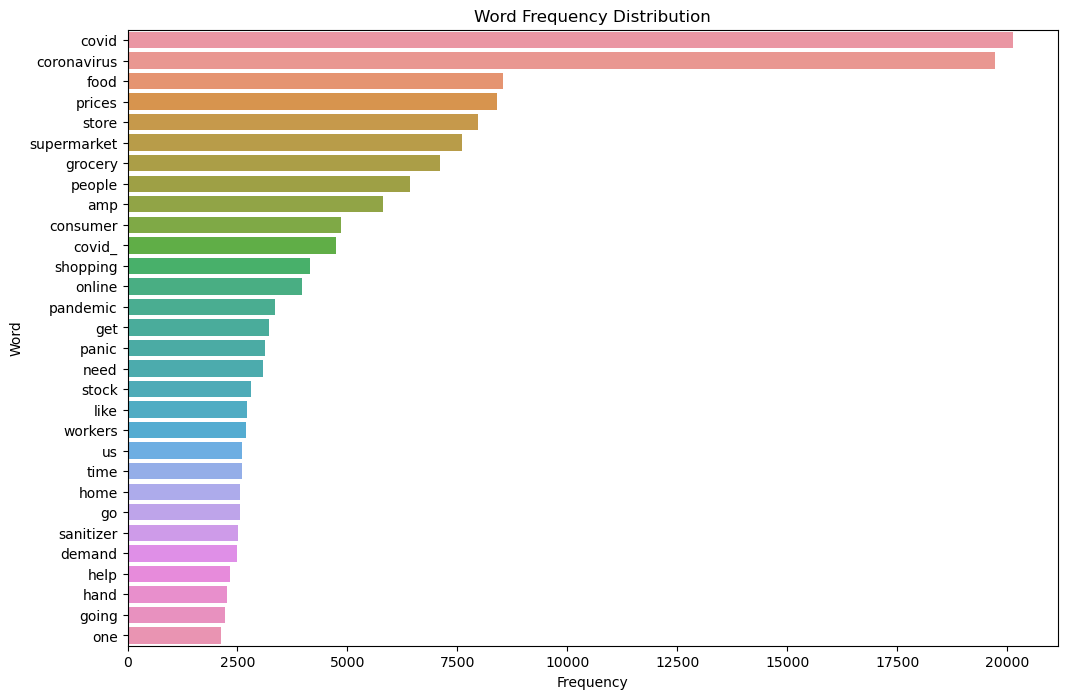

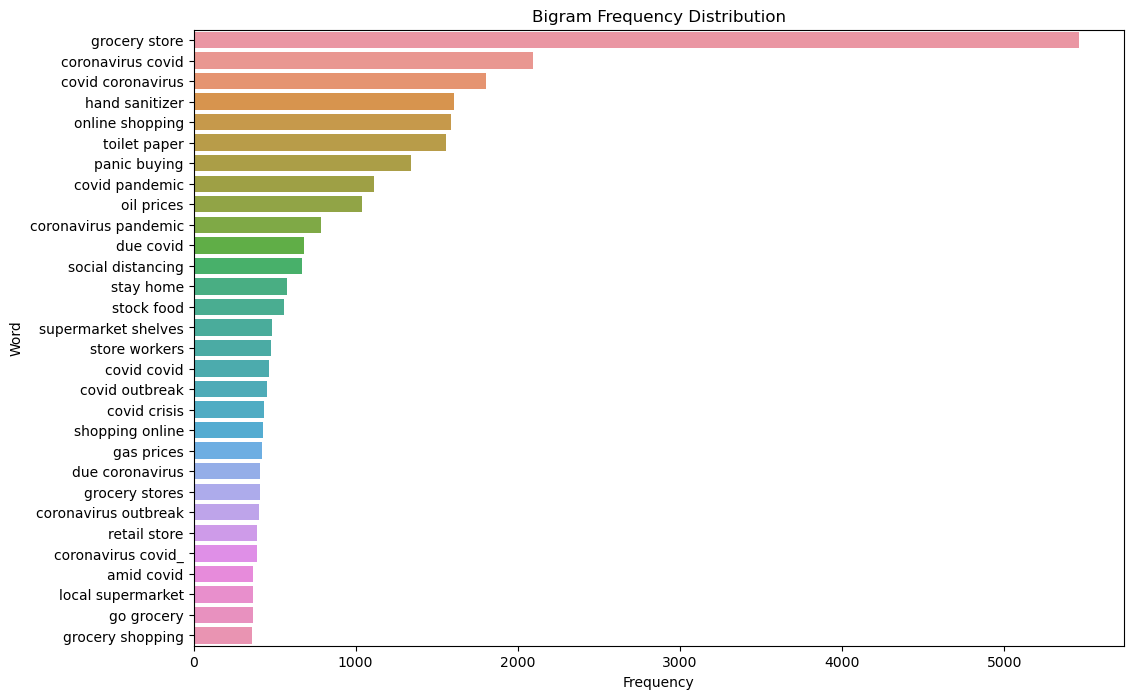

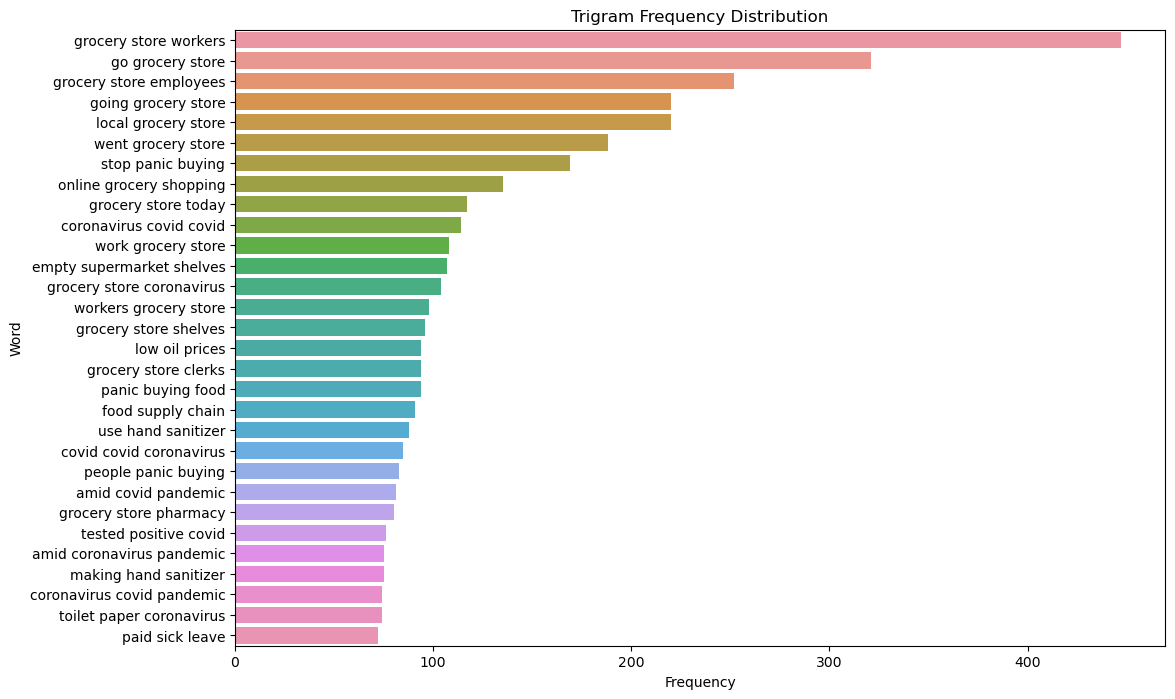

In [60]:
def plot_word_frequency(df, column, n_most_common=30, ngram_range=(1, 1), title='Word Frequency Distribution'):
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    words_matrix = count_vectorizer.fit_transform(df[column])
    words_sum = words_matrix.sum(axis=0)
    words_freq = [(word, words_sum[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n_most_common]
    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

    plt.figure(figsize=(12, 8))
    sns.barplot(y='Word', x='Frequency', data=df_common_words, orient='h')
    plt.title(title)
    plt.show()

# Visualize the most frequent words
plot_word_frequency(df_tweets, 'CleanTweet', title='Word Frequency Distribution')

# Visualize the most frequent bigrams
plot_word_frequency(df_tweets, 'CleanTweet', ngram_range=(2, 2), title='Bigram Frequency Distribution')

# Visualize the most frequent trigrams
plot_word_frequency(df_tweets, 'CleanTweet', ngram_range=(3, 3), title='Trigram Frequency Distribution')


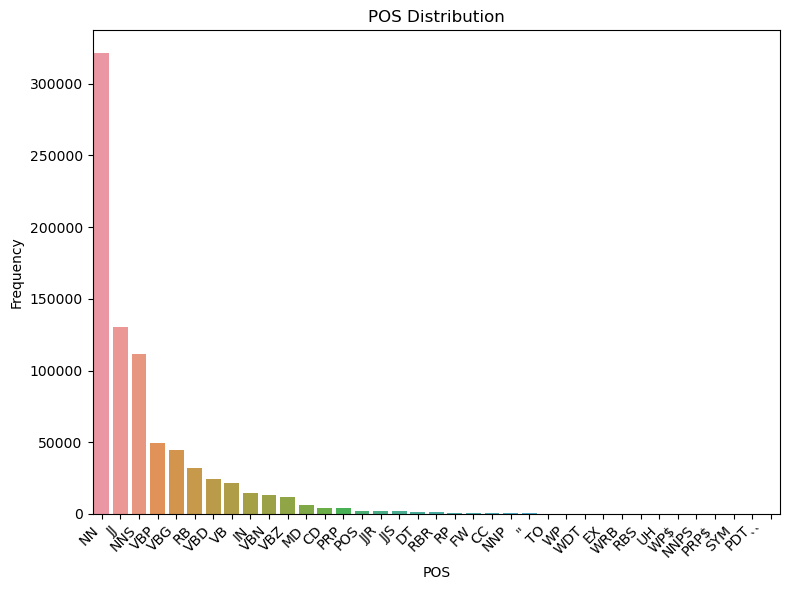

In [61]:
def plot_pos_distribution(df, column, title='POS Distribution'):
    # Tokenize and POS tag the tweets
    all_pos_tags = []
    for tweet in df[column]:
        tokens = nltk.word_tokenize(tweet)
        pos_tags = nltk.pos_tag(tokens)
        all_pos_tags.extend([tag for _, tag in pos_tags])

    # Count the occurrences of each POS tag
    pos_counter = Counter(all_pos_tags)

    # Create a dataframe from the POS tag counter
    df_pos = pd.DataFrame.from_dict(pos_counter, orient='index').reset_index()
    df_pos.columns = ['POS', 'Frequency']
    df_pos.sort_values(by='Frequency', ascending=False, inplace=True)

    # Plot the POS distribution
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='POS', y='Frequency', data=df_pos)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_pos_distribution(df_tweets, 'CleanTweet')

### Visualize class distribution in Cleaned tweets

In [67]:
print('y_train:')
print(y_train.value_counts())
print('y_val:')
print(y_val.value_counts())
print('y_test:')
print(y_test.value_counts())

y_train:
2    16370
0    14002
1     6962
Name: Sentiment, dtype: int64
y_val:
2    1674
0    1395
1     727
Name: Sentiment, dtype: int64
y_test:
0    1633
2    1546
1     617
Name: Sentiment, dtype: int64


In [66]:
# Total pre-processed tweets
len(y_train)+len(y_val)+len(y_test)

44926

In [68]:
# Concatenate the y_train, y_val, and y_test series
y = pd.concat([y_train, y_val, y_test])
# Class distribution
y.value_counts()

2    19590
0    17030
1     8306
Name: Sentiment, dtype: int64

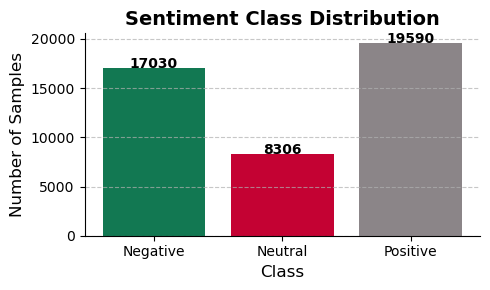

In [69]:
# Count the number of occurrences of each class
class_counts = y.value_counts()
# Reordering the index
class_counts = class_counts.reindex([0, 1, 2])

# Create a bar plot
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(['Negative', 'Neutral', 'Positive'], class_counts.values, color=['red', 'blue', 'green'])

# Set the color of the bar fill to greyscale
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)

# Add text labels for each bar
for i, v in enumerate(class_counts.values):
    ax.text(i, v+20, str(v), color='black', fontweight='bold', ha='center')

# Set axis labels and title
ax.set_xlabel('Class', fontsize=12 )
ax.set_ylabel('Number of Samples', fontsize=12 )
ax.set_title('Sentiment Class Distribution', fontsize=14, fontweight='bold')

# Format tick labels
ax.tick_params(axis='both', which='major', labelsize=10)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Tighten the layout
plt.tight_layout()

# save the plot as a high-resolution PDF file
plt.savefig('images/sentiment_class_distribution.pdf', dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

### Plot all Precision-Recall Curves to compare

In [2]:
# load the array from file
precision_micro_bow = np.load('Precision-Recall Curves/precision_micro_bow_SMOTE.npy')
recall_micro_bow = np.load('Precision-Recall Curves/recall_micro_bow_SMOTE.npy')

# load the array from file
precision_micro_tfidf = np.load('Precision-Recall Curves/precision_micro_tfidf_SMOTE.npy')
recall_micro_tfidf = np.load('Precision-Recall Curves/recall_micro_tfidf_SMOTE.npy')

# load the array from file
precision_micro_w2vec = np.load('Precision-Recall Curves/precision_micro_w2vec.npy')
recall_micro_w2vec = np.load('Precision-Recall Curves/recall_micro_w2vec.npy')

# load the array from file
precision_micro_GloVe = np.load('Precision-Recall Curves/precision_micro_GloVe.npy')
recall_micro_GloVe = np.load('Precision-Recall Curves/recall_micro_GloVe.npy')

# load the array from file
precision_micro_fasttext = np.load('Precision-Recall Curves/precision_micro_fasttext.npy')
recall_micro_fasttext = np.load('Precision-Recall Curves/recall_micro_fasttext.npy')

# load the array from file
precision_micro_roberta = np.load('Precision-Recall Curves/precision_micro_RoBERTa.npy')
recall_micro_roberta = np.load('Precision-Recall Curves/recall_micro_RoBERTa.npy')


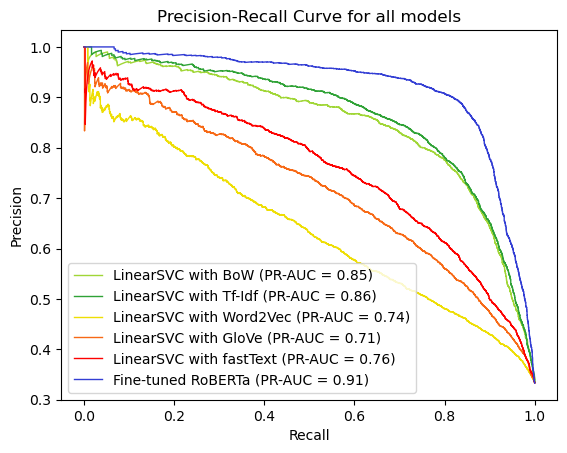

In [3]:
# Plot micro-average curve
plt.plot(recall_micro_bow, precision_micro_bow, color='#A0D636', lw=1,
         label='LinearSVC with BoW (PR-AUC = 0.85)')

plt.plot(recall_micro_tfidf, precision_micro_tfidf, color='#2FA236', lw=1,
         label='LinearSVC with Tf-Idf (PR-AUC = 0.86)')

plt.plot(recall_micro_w2vec, precision_micro_w2vec, color='#EEDE04', lw=1,
         label='LinearSVC with Word2Vec (PR-AUC = 0.74)')

plt.plot(recall_micro_GloVe, precision_micro_GloVe, color='#F76915', lw=1,
         label='LinearSVC with GloVe (PR-AUC = 0.71)')

plt.plot(recall_micro_fasttext, precision_micro_fasttext, color='#FD0100', lw=1,
         label='LinearSVC with fastText (PR-AUC = 0.76)')

plt.plot(recall_micro_roberta, precision_micro_roberta, color='#333ED4', lw=1,
         label='Fine-tuned RoBERTa (PR-AUC = 0.91)')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best', fontsize=10)
plt.title('Precision-Recall Curve for all models')

# save the plot as a high-resolution PDF file
plt.savefig('images/precision_recall_curves.pdf', dpi=300, format='pdf', bbox_inches='tight')


plt.show()